# How to use `Context` to pass data between nodes

## Introduction
In AiiDA workflow, the context is a internal data container that can hold and pass information between steps. It is very usefull for complex workflows.

Load the AiiDA profile.

In [2]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='4a9501fb20364cecb99920cadf27b238' name='xing'>

## Pass data to context

There are two ways to pass data to context.

- Initialize the context data when creating the WorkTree.
  ```python
  wt = WorkTree(name="test_worktree_ctx")
  # set ctx.x = Int(2), ctx.data.y = Int(3)
  wt.ctx = {"x": Int(2), "data.y": Int(3)}
  ```

- Export the node result to context.
  ```python
  add1 = wt.nodes.new(add, "add1", x=2, y=3)
  # set result of add1 to ctx.sum
  add1.to_ctx = [["result", "sum"]]
  ```

### Nested context keys
To organize the context data (e.g. group data), The keys may contain dots `.`, which will creating dictionary in the context. Here is an example, to group the results of all add nodes to `ctx.sum`:

```python
add1.to_ctx = [["result", "sum.add1"]]
add2.to_ctx = [["result", "sum.add2"]]
```
here, `ctx.sum` will be:
```python
{"add1": value1, "add2": value2}
```

## Use data from context
There are two ways to use data from context:

- One can use the `{{name}}` syntax in the inputs of the node.
    
    ```python
    add1 = wt.nodes.new(add, "add1", x="{{x}}", y=3)
    ```
    One can also use nested context keys, like `{{sum.add1}}`.
- One can export the data from context to the node group outputs.
    
    ```python
    @node.group(outputs=[["ctx.sum", "result"]])
    def my_while(n, limit):
        nt = WorkTree("while_worktree")
        add1 = wt.nodes.new(add, x=2, y=3)
        add2 = wt.nodes.new(add, x=2, y=3)
        add1.to_ctx = [["result", "sum.add1"]]
        add2.to_ctx = [["result", "sum.add2"]]
    ```

## First workflow

In [4]:
from aiida_worktree import node, WorkTree
from aiida.engine import calcfunction
from aiida.orm import Int

# define add node
@node()
@calcfunction
def add(x, y):
    return x + y

wt = WorkTree(name="test_worktree_ctx")
wt.ctx = {"x": Int(2)}
add1 = wt.nodes.new(add, "add1", x="{{x}}", y=3)
wt.submit(wait=True)

[INFO] 2023-08-04 09:04:42 nodetree: Create NodeTree: test_worktree_ctx


### Check status and results


In [5]:
print("State of WorkTree         : {}".format(wt.state))
print('Result of add1            : {}'.format(wt.nodes["add1"].node.outputs.result.value))

State of WorkTree         : FINISHED
Result of add1            : 5


Generate node graph from the AiiDA process,and we can see that the `multiply` node is executed.

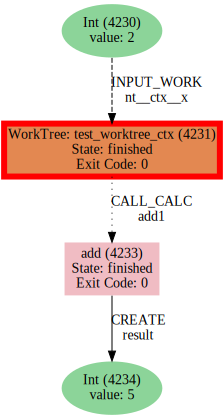

In [8]:
from aiida_worktree.utils import generate_node_graph
generate_node_graph(wt.pk)

> **_NOTE:_**  If you pass data from node to node trough context, you may need to use `wait` to wait for the data to be ready. See [How to wait for another node](wait.ipynb).